In [31]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
test = pd.read_csv("../data/drugcell_test.txt", sep="\t", header=None, names=(['cell', 'drug', 't_auc']))

predicted = pd.read_csv("../result/drugcell.predict", header=None, names=(['p_auc']))
predicted_bb = pd.read_csv("../result/drugcell_bb.predict", header=None, names=(['p_auc']))

#test_orig = pd.read_csv("../data/drugcell_test.txt", sep="\t", header=None, names=(['cell', 'drug', 't_auc']))
#predicted_orig = pd.read_csv("drugcell_orig.predict", header=None, names=(['p_auc']))


In [30]:
def get_boxplot(test, predicted):
    
    df = pd.DataFrame(list(zip(test['t_auc'], predicted['p_auc'])), columns=['t', 'p'])
    df = df.sort_values(by=['t'])

    data = []
    for i in range(9):
        temp = []
        data.append(temp)

    for i, row in df.iterrows():
        if row['t'] < 0.3:
            data[0].append(row['p'])
        elif row['t'] < 0.4:
            data[1].append(row['p'])
        elif row['t'] < 0.5:
            data[2].append(row['p'])
        elif row['t'] < 0.6:
            data[3].append(row['p'])
        elif row['t'] < 0.7:
            data[4].append(row['p'])
        elif row['t'] < 0.8:
            data[5].append(row['p'])
        elif row['t'] < 0.9:
            data[6].append(row['p'])
        elif row['t'] < 1.0:
            data[7].append(row['p'])
        else:
            data[8].append(row['p'])
    
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111)
    bp = ax.boxplot(data, showfliers=False, labels=['0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0', 'Inf'])
    ax.grid()
    plt.show()


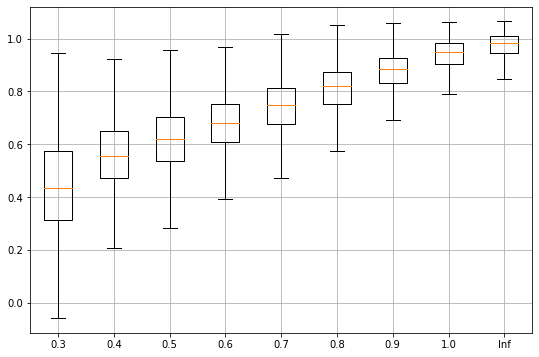

In [4]:
#NeST data CV

get_boxplot(test, predicted)

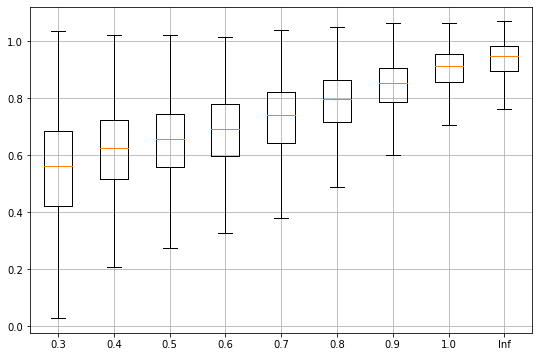

In [5]:
#NeST Black box

get_boxplot(test, predicted_bb)

In [6]:
def load_mapping(mapping_file):
    mapping = {}
    file_handle = open(mapping_file)
    for line in file_handle:
        line = line.rstrip().split()
        mapping[line[1]] = int(line[0])
    file_handle.close()
    return mapping


def load_test_data(file_name, cell2id, drug2id):
    feature = []
    label = []
    with open(file_name, 'r') as fi:
        for line in fi:
            tokens = line.strip().split('\t')
            feature.append([cell2id[tokens[0]], drug2id[tokens[1]]])
            label.append([float(tokens[2])])
    return feature, label


def pearson_corr(x, y):
    xx = x - np.mean(x)
    yy = y - np.mean(y)
    return np.sum(xx*yy) / (np.linalg.norm(xx, 2) * np.linalg.norm(yy, 2))



In [23]:
cell_id_mapping = load_mapping('../data/cell2ind.txt')
drug_id_mapping = load_mapping('../data/drug2ind.txt')

test_feature, test_label = load_test_data("../data/drugcell_test.txt", cell_id_mapping, drug_id_mapping)
predicted_label = np.array(predicted)
predicted_bb_label = np.array(predicted_bb)

In [24]:
corr = pearson_corr(predicted_label, test_label)
print(corr)

0.8059636882180176


In [25]:
corr = pearson_corr(predicted_bb_label, test_label)
print(corr)

0.6457917156663441


In [27]:
drug_ids = set([d[1] for d in test_feature])

drug_pred_corr = []
drug_p_bb_corr = []

for drug in drug_ids:
    test_vals = []
    pred_vals = []
    p_bb_vals = []
    
    for i, feature in enumerate(test_feature):
        if feature[1] == drug:
            test_vals.append(test_label[i])
            pred_vals.append(predicted_label[i])
            p_bb_vals.append(predicted_bb_label[i])
            
    p_corr = pearson_corr(np.array(pred_vals), np.array(test_vals))
    p_bb_coor = pearson_corr(np.array(p_bb_vals), np.array(test_vals))
    drug_pred_corr.append(p_corr)
    drug_p_bb_corr.append(p_bb_coor)
    


684
684


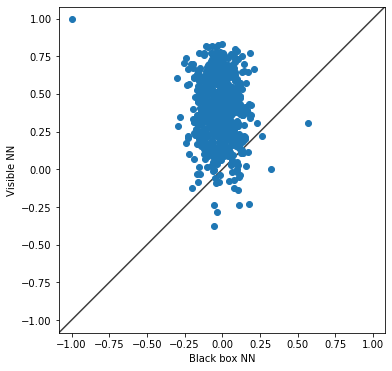

In [35]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
ax.scatter(drug_p_bb_corr, drug_pred_corr)

plt.xlabel("Black box NN")
plt.ylabel("Visible NN")

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.show()